# Finding a better place around Johannesburg

# 1. Importing and installing libraries

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import requests
import folium

In [3]:

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
import os

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


In [4]:
conda install -c anaconda xlrd --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - xlrd


The following packages will be UPDATED:

  conda                      pkgs/main::conda-4.7.12-py37_0 --> anaconda::conda-4.8.3-py37_0

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl                                         pkgs/main --> anaconda
  xlrd                                            pkgs/main --> anaconda


Preparing transaction: ...working... done
Verifying transaction: ...working... failed

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




In [5]:
conda install -c anaconda lxml --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - lxml


The following packages will be UPDATED:

  conda                      pkgs/main::conda-4.7.12-py37_0 --> anaconda::conda-4.8.3-py37_0

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl                                         pkgs/main --> anaconda


Preparing transaction: ...working... done
Verifying transaction: ...working... failed

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




# 2. Data Extraction and Cleaning

!! Using Python tools such as pandas dataframe to scrape data from the website for postal codes https://cocl.us/new_york/dataset

Using geolocator return the longitude and latitude of New York, with the assistance of Foursquare API

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [7]:

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20200717' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:

def get_venue_details(venue_id):
        
    CLIENT_ID = ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [10]:
new_york_data=get_new_york_data()

In [11]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
# Latitude and longitude of Neighborhoods
new_york_data.describe()

,Latitude,Longitude
count,306.000000,306.000000
mean,40.701362,-73.946254
std,0.097498,0.121202
min,40.505334,-74.246569
25%,40.617778,-74.000062
50%,40.702969,-73.932009
75%,40.766645,-73.857525
max,40.908543,-73.708847


In [13]:
#Boroughs in New York
new_york_data["Borough"]

0              Bronx
1              Bronx
2              Bronx
3              Bronx
4              Bronx
5              Bronx
6          Manhattan
7              Bronx
8              Bronx
9              Bronx
10             Bronx
11             Bronx
12             Bronx
13             Bronx
14             Bronx
15             Bronx
16             Bronx
17             Bronx
18             Bronx
19             Bronx
20             Bronx
21             Bronx
22             Bronx
23             Bronx
24             Bronx
25             Bronx
26             Bronx
27             Bronx
28             Bronx
29             Bronx
30             Bronx
31             Bronx
32             Bronx
33             Bronx
34             Bronx
35             Bronx
36             Bronx
37             Bronx
38             Bronx
39             Bronx
40             Bronx
41             Bronx
42             Bronx
43             Bronx
44             Bronx
45             Bronx
46          Brooklyn
47          B

In [14]:
#Neighborhoods in within the New York dataframe
new_york_data["Neighborhood"]

0                      Wakefield
1                     Co-op City
2                    Eastchester
3                      Fieldston
4                      Riverdale
5                    Kingsbridge
6                    Marble Hill
7                       Woodlawn
8                        Norwood
9                 Williamsbridge
10                    Baychester
11                Pelham Parkway
12                   City Island
13                  Bedford Park
14            University Heights
15                Morris Heights
16                       Fordham
17                  East Tremont
18                    West Farms
19                  High  Bridge
20                       Melrose
21                    Mott Haven
22                   Port Morris
23                      Longwood
24                   Hunts Point
25                    Morrisania
26                     Soundview
27                  Clason Point
28                   Throgs Neck
29                  Country Club
30        

No handles with labels found to put in legend.


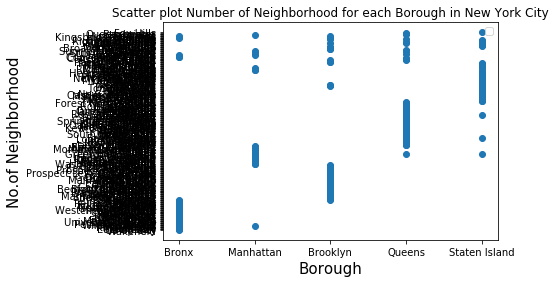

In [15]:
# Scatter plot of Boroughs in New York agaisnt the number of neighborhoods
x= new_york_data["Borough"]
y=new_york_data["Neighborhood"]
# title
plt.title('Scatter plot Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#scatter plot
plt.scatter(x,y)
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
# Value counts of the Boroughs
new_york_data['Borough'].value_counts().to_frame()

,Borough
Queens,81
Brooklyn,70
Staten Island,63
Bronx,52
Manhattan,40


In [17]:
print(new_york_data.Borough.unique())

['Bronx' 'Manhattan' 'Brooklyn' 'Queens' 'Staten Island']


In [18]:
import time
start_time = time.time()

address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

print("--- %s seconds ---" % round((time.time() - start_time), 2))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.
--- 0.57 seconds ---


In [19]:
map_new_york_data = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_york_data['Latitude'], new_york_data['Longitude'], new_york_data['Borough'], new_york_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new_york_data)  
    
map_new_york_data

In [20]:

CLIENT_ID = 'C3VQHGRL2GFETMSCP2DVCUKRJWCQWKI20AJODLNLQLZTL1ZK' # your Foursquare ID
CLIENT_SECRET = 'JZU555K01LXPUDW14YQCJ53NEFAVKJ1FILY51O2HN3OKZAZ4' # your Foursquare Secret
VERSION = '20200718' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: C3VQHGRL2GFETMSCP2DVCUKRJWCQWKI20AJODLNLQLZTL1ZK
CLIENT_SECRET:JZU555K01LXPUDW14YQCJ53NEFAVKJ1FILY51O2HN3OKZAZ4


In [21]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=200, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
new_york_data_venues = getNearbyVenues(names=new_york_data['Neighborhood'],
                                  latitudes=new_york_data['Latitude'],
                                  longitudes=new_york_data['Longitude'],
                                  LIMIT=200)

print('The "new_york_data_venues" dataframe has {} venues and {} unique venue types.'.format(
      len(new_york_data_venues['Venue Category']),
      len(new_york_data_venues['Venue Category'].unique())))

new_york_data_venues.to_csv('new_york_data_venues.csv', sep=',', encoding='UTF8')
new_york_data_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

KeyError: 'groups'

In [25]:
# Tuples of the dataframe
colnames = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
new_york_data_venues = pd.read_csv('new_york_data_venues.csv', skiprows=1, names=colnames)
new_york_data_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop


In [26]:
# Sorting values of the Venue category in no ascending order 
new_york_data_venues.groupby('Venue Category')['Venue'].count().sort_values(ascending=False)

Venue Category
Pizza Place                                 1017
Coffee Shop                                  584
Italian Restaurant                           542
Deli / Bodega                                475
Bakery                                       474
Donut Shop                                   444
Park                                         431
Sandwich Place                               424
Bar                                          423
Grocery Store                                414
Chinese Restaurant                           388
Pharmacy                                     378
Bank                                         332
Mexican Restaurant                           328
Ice Cream Shop                               327
American Restaurant                          304
Café                                         299
Fast Food Restaurant                         280
Supermarket                                  271
Gym                                          264
Carib

In [27]:
new_york_data_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,63,63,63,63,63,63
Annadale,17,17,17,17,17,17
Arden Heights,21,21,21,21,21,21
Arlington,20,20,20,20,20,20
Arrochar,24,24,24,24,24,24
Arverne,34,34,34,34,34,34
Astoria,100,100,100,100,100,100
Astoria Heights,75,75,75,75,75,75
Auburndale,99,99,99,99,99,99


In [28]:
print('There are {} uniques categories.'.format(len(new_york_data_venues['Venue Category'].unique())))

There are 481 uniques categories.


In [29]:
# one hot encoding
new_york_data_onehot = pd.get_dummies(new_york_data_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
new_york_data_onehot['Neighborhood'] = new_york_data_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [new_york_data_onehot.columns[-1]] + list(new_york_data_onehot.columns[:-1])
new_york_data_onehot = new_york_data_onehot[fixed_columns]
new_york_data_grouped = new_york_data_onehot.groupby('Neighborhood').mean().reset_index()
new_york_data_onehot.head(5)

,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Stor

In [30]:
restaurant_List = []
search = 'Restaurant'
for i in new_york_data_onehot.columns :
    if search in i:
        restaurant_List.append(i)

In [31]:
restaurant_List

['Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Brazilian Restaurant',
 'Burmese Restaurant',
 'Cajun / Creole Restaurant',
 'Cambodian Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Dim Sum Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Egyptian Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Gluten-free Restaurant',
 'Greek Restaurant',
 'Halal Restaurant',
 'Hawaiian Restaurant',
 'Himalayan Restaurant',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Indonesian Restaurant',
 'Israeli Restaurant',
 'Italian Rest

In [32]:
num_top_venues = 5
for hood in new_york_data_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =new_york_data_grouped[new_york_data_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Allerton ----
                  venue  freq
0           Pizza Place  0.10
1            Donut Shop  0.06
2           Supermarket  0.05
3  Caribbean Restaurant  0.05
4        Sandwich Place  0.05


---- Annadale ----
                 venue  freq
0                Trail  0.12
1           Restaurant  0.12
2  American Restaurant  0.12
3          Pizza Place  0.12
4                  Bar  0.06


---- Arden Heights ----
               venue  freq
0           Bus Stop  0.10
1               Park  0.10
2      Deli / Bodega  0.05
3  Elementary School  0.05
4      Garden Center  0.05


---- Arlington ----
            venue  freq
0   Deli / Bodega  0.15
1  Hardware Store  0.10
2  Discount Store  0.05
3      Donut Shop  0.05
4  Nightlife Spot  0.05


---- Arrochar ----
                venue  freq
0      Baseball Field  0.08
1            Bus Stop  0.08
2  Italian Restaurant  0.08
3               Beach  0.08
4       Deli / Bodega  0.04


---- Arverne ----
           venue  freq
0      Surf Spot  0.

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = new_york_data_grouped['Neighborhood']

for ind in np.arange(new_york_data_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(new_york_data_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Donut Shop,Supermarket,Sandwich Place,Pharmacy,Fast Food Restaurant,Caribbean Restaurant,Fried Chicken Joint,Bar,Deli / Bodega
1,Annadale,Trail,Restaurant,Pizza Place,American Restaurant,Cosmetics Shop,Business Service,Pharmacy,Bar,Train Station,Home Service
2,Arden Heights,Bus Stop,Park,Sushi Restaurant,Sandwich Place,Optical Shop,Deli / Bodega,Garden Center,Mexican Restaurant,Shopping Mall,Pharmacy
3,Arlington,Deli / Bodega,Hardware Store,Snack Place,Nightlife Spot,Boat or Ferry,Grocery Store,Comic Shop,Donut Shop,Convenience Store,Bus Stop
4,Arrochar,Baseball Field,Italian Restaurant,Bus Stop,Beach,Steakhouse,Supermarket,Outdoors & Recreation,Park,Hotel,Middle Eastern Restaurant


# Clustering the Neighborhood using K-Means

In [48]:
# Using K-Means to cluster neighborhood into 3 clusters
new_york_data_grouped_clustering = new_york_data_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(new_york_data_grouped_clustering)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2,
       1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0, 1, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2,
       2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1,

In [49]:
# set number of clusters
kclusters = 2

new_york_data_grouped_clustering = new_york_data_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(new_york_data_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,

In [50]:
#Cleaning the dataframe
col_name = []
col_name = ['Neighborhood'] + restaurant_List
new_york_data_restaurant = new_york_data_onehot[col_name]
new_york_data_restaurant = new_york_data_restaurant.iloc[:,1::]

In [51]:
new_york_data_results = pd.DataFrame(kmeans.cluster_centers_)
new_york_data_results.columns = new_york_data_grouped_clustering.columns
new_york_data_results.index = ['cluster0','cluster1']
new_york_data_results['Total Sum'] = new_york_data_results.sum(axis = 1)
new_york_data_results

,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mobility Stor

In [52]:
new_york_data_results_merged = pd.DataFrame(new_york_data_grouped['Neighborhood'],)

new_york_data_results_merged = new_york_data_results_merged.assign(Cluster_Labels = kmeans.labels_)

In [53]:
kclusters = 10

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(new_york_data_results_merged['Latitude'], 
                                   new_york_data_results_merged['Longitude'], 
                                   new_york_data_results_merged['Neighborhood'], 
                                   new_york_data_results_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


KeyError: 'Latitude'

In [55]:
print(new_york_data_results_merged.shape)
new_york_data_results_merged

(302, 2)


,Neighborhood,Cluster_Labels
0,Allerton,0
1,Annadale,0
2,Arden Heights,0
3,Arlington,0
4,Arrochar,1
5,Arverne,0
6,Astoria,1
7,Astoria Heights,0
8,Auburndale,0
9,Bath Beach,0


In [56]:
new_york_housing=pd.read_csv('housing-new-york-units-by-building.csv')

In [57]:
new_york_housing.head()

,Project ID,Project Name,Program Group,Project Start Date,Project Completion Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,Community Board,Council District,Census Tract,NTA - Neighborhood Tabulation Area,Latitude,Longitude,Latitude (Internal),Longitude (Internal),Building Completion Date,Reporting Construction Type,Extended Affordability Only,Prevailing Wage Status,Extremely Low Income Units,Very Low Income Units,Low Income Units,Moderate Income Units,Middle Income Units,Other Income Units,Studio Units,1-BR Units,2-BR Units,3-BR Units,4-BR Units,5-BR Units,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units
0,64390,COOPER SQUARE MHA - PHASE 1.GHPP.FY20,Multifamily Finance Program,2020-03-31T00:00:00.000,NaN,1564.0,83,2 AVENUE,Manhattan,10003.0,1.004600e+09,1006591.0,MN-03,2.0,38,MN22,40.726642,-73.989101,40.72676,-73.989368,2020-03-31T00:00:00.000,Preservation,No,Non Prevailing Wage,0,4,0,0,0,0,0,0,0,4,0,0,0,0,1,3,4,4
1,64390,COOPER SQUARE MHA - PHASE 1.GHPP.FY20,Multifamily Finance Program,2020-03-31T00:00:00.000,NaN,10537.0,13,EAST 3 STREET,Manhattan,10003.0,1.004590e+09,1077971.0,MN-03,2.0,38,MN22,40.726061,-73.990984,40.72620,-73.990811,2020-03-31T00:00:00.000,Preservation,No,Non Prevailing Wage,0,10,0,0,0,0,2,6,2,0,0,0,0,0,1,9,10,10
2,64390,COOPER SQUARE MHA - PHASE 1.GHPP.FY20,Multifamily Finance Program,2020-03-31T00:00:00.000,NaN,10557.0,21,EAST 3 STREET,Manhattan,10003.0,1.004590e+09,1077972.0,MN-03,2.0,38,MN22,40.725932,-73.990677,40.72608,-73.990486,2020-03-31T00:00:00.000,Preservation,No,Non Prevailing Wage,15,1,0,0,0,0,6,5,5,0,0,0,0,0,5,11,16,16
3,64390,COOPER SQUARE MHA - PHASE 1.GHPP.FY20,Multifamily Finance Program,2020-03-31T00:00:00.000,NaN,10569.0,23,EAST 3 STREET,Manhattan,10003.0,1.004590e+09,1077973.0,MN-03,2.0,38,MN22,40.725901,-73.990602,40.72605,-73.990403,2020-03-31T00:00:00.000,Preservation,No,Non Prevailing Wage,14,3,0,0,0,0,8,6,3,0,0,0,0,0,3,14,17,17
4,64390,COOPER SQUARE MHA - PHASE 1.GHPP.FY20,Multifamily Finance Program,2020-03-31T00:00:00.000,NaN,10580.0,25,EAST 3 STREET,Manhattan,10003.0,1.004590e+09,1077974.0,MN-03,2.0,38,MN22,40.725868,-73.990526,40.72601,-73.990327,2020-03-31T00:00:00.000,Preservation,No,Non Prevailing Wage,17,1,0,0,0,0,9,7,2,0,0,0,0,0,2,16,18,18


In [40]:
new_york_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551 entries, 0 to 4550
Data columns (total 42 columns):
Project ID                            4551 non-null int64
Project Name                          4551 non-null object
Program Group                         4551 non-null object
Project Start Date                    4551 non-null object
Project Completion Date               3234 non-null object
Building ID                           3597 non-null float64
Number                                4551 non-null object
Street                                4551 non-null object
Borough                               4551 non-null object
Postcode                              3549 non-null float64
BBL                                   3501 non-null float64
BIN                                   3178 non-null float64
Community Board                       4551 non-null object
Council District                      4542 non-null float64
Census Tract                          3555 non-null object
NTA 

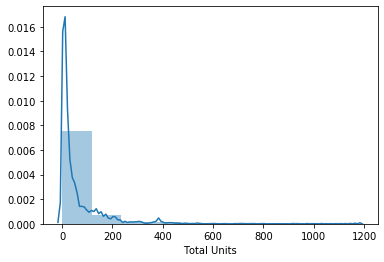

In [41]:
import seaborn as sns
sns.distplot(new_york_housing['Total Units'],bins=10)

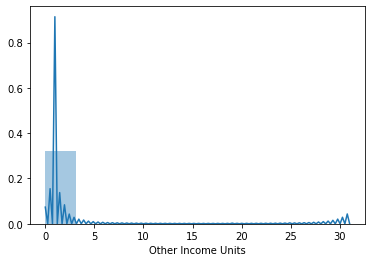

In [42]:
import seaborn as sns
sns.distplot(new_york_housing['Other Income Units'],bins=10)

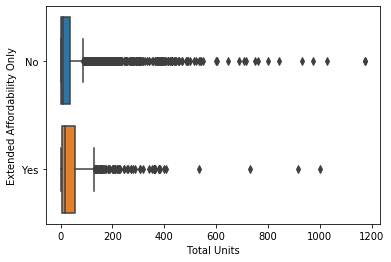

In [43]:
sns.boxplot(x='Total Units', y= 'Extended Affordability Only', data=new_york_housing)